<a href="https://colab.research.google.com/github/Athe-kunal/Reinforcement-learning-trading-agent-using-Google-trends-data/blob/main/Amazon_With_Google_trends_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%%capture
#!pip install yfinance
#!pip install stockstats
#!pip install lz4
#!pip install alpaca_trade_api
#!pip install trading_calendars
#!pip install wrds
#!pip install pyfolio
#!pip install stable_baselines3[extra]
#!pip3 install optuna

In [35]:
!git clone https://github.com/smallmin82465/Stock-prediction.git

Cloning into 'Stock-prediction'...


In [36]:
import os
os.chdir('Stock-prediction/')

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split

from finrl.neo_finrl.env_stock_trading.StockEnvV2 import StockTradingEnvV2
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent


from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import yfinance as yf
import sys
import optuna
from stable_baselines3 import PPO


# sys.path.append('../FinRL-library')
from pprint import pprint

In [38]:
pytrends_file = os.listdir("Pytrends")
pytrends_file

['Amazon_13.csv',
 'Apple_5.csv',
 'Bitcoin_107.csv',
 'Dogecoin_107.csv',
 'Ethereum_107.csv',
 'Facebook_13.csv',
 'Google_13.csv',
 'Microsoft_13.csv',
 'Pytrends_data.txt',
 'Tesla_47.csv',
 'test']

In [39]:
def chaikin_df(df, roll):
    # Money flow volume
    mfv = ((df['Close']-df['Low']) - (df['High']-df['Close'])) / \
        (df['High']-df['Low'])
    mfv = mfv.fillna(0.0)
    mfv *= df['Volume']
    cmf = (mfv.rolling(roll, min_periods=0).sum()
           / df['Volume'].rolling(roll, min_periods=0).sum())
    cmf = cmf.replace([np.inf, -np.inf], np.nan).fillna(0)
    df['cmf'] = cmf
    # df[df['CMF'] > 0]['CMF'].clip(0.05, 1)
    # df[df['CMF'] <= 0]['CMF'].clip(-1, -0.05)
    return df

In [40]:
ticker_list = ['AMZN']
names = ['Amazon']
train_start_date = '2012-01-01'
train_end_date = '2016-12-31'

val_start_date = '2017-01-01'
val_end_date = '2017-12-31'

test_start_date = '2018-01-01'
test_end_date = '2019-12-31'

In [41]:
def fetch_data(ticker_list,names):
    '''
    For the ticker list, it will download, include Chaikin and Pytrends
    Append to the dataframe
    '''

    data_df = pd.DataFrame()
    for tic,name in zip(ticker_list,names):
        temp_df = yf.download(tic, start=train_start_date, end=test_end_date)
        temp_df['tic'] = tic
        temp_df = chaikin_df(temp_df, 20)
        temp_df = temp_df.reset_index()
        for files in pytrends_file:
          if files.split('_')[0] in names:
            pytrends_df = pd.read_csv(os.getcwd()+'/Pytrends/'+files)
            pytrends_df.columns = ['Date','pytrends']
            temp_df['Date'] = temp_df.Date.apply(lambda x: x.strftime("%Y-%m-%d"))
            temp_df = temp_df.merge(pytrends_df,how='left',left_on='Date',right_on='Date')
        data_df = data_df.append(temp_df)
    # data_df = data_df.reset_index()
    data_df.columns = [
        "date",
        "open",
        "high",
        "low",
        "close",
        "adjcp",
        "volume",
        "tic",
        'cmf',
        'pytrends'
    ]
    data_df['close'] = data_df['adjcp']

    data_df = data_df.drop('adjcp',axis=1)

    # data_df['day'] = data_df['date'].dt.dayofweek

    # data_df['date'] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))

    
    data_df = data_df.sort_values(by=['date','tic']).reset_index(drop=True)
    data_df.dropna(inplace=True)

    return data_df

In [42]:
def preprocess_split(start_date,end_date,ticker_list,names):
  data_df = fetch_data(ticker_list,names)
  fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=False,
                    user_defined_feature = False)

  processed = fe.preprocess_data(data_df)
  
  # processed.to_csv(f'{names[0]}_final.csv')
  # processed = pd.read_csv(f'{names[0]}_final.csv',index_col=[0])
  processed['p_into_cmf'] = processed['cmf'] * processed['pytrends']
  processed['p_into_cmf/100'] = processed['cmf'] * processed['pytrends'] / 100
  
  train = data_split(processed, train_start_date,train_end_date)
  val = data_split(processed,val_start_date,val_end_date)
  trade = data_split(processed, test_start_date,test_end_date)
  print(len(train))
  print(len(val))
  print(len(trade))

  return train,val,trade

In [43]:
def sample_ppo_params(trial:optuna.Trial):
  # Episode length is a categorical hyperparamter
  n_steps = trial.suggest_categorical("n_steps", [512, 1024, 2048])
  #Entropy coefficient for exploration-exploitation
  ent_coef = trial.suggest_loguniform("ent_coef", 0.0001, 0.1)
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
  batch_size = trial.suggest_categorical("batch_size", [ 64, 128, 256])
  
  return {"n_steps":n_steps,
          "ent_coef":ent_coef,
          "learning_rate":learning_rate,
          "batch_size":batch_size}
def calculate_sharpe(df):
  df['daily_return'] = df['total_assets'].pct_change(1)
  if df['daily_return'].std() !=0:
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
          df['daily_return'].std()
    return sharpe
  else:
    return 0

In [44]:
from IPython.display import clear_output
import os
# ticker_list = ['AMZN','AAPL','FB','GOOGL','MSFT']
# names = ['Amazon','Apple','Facebook','Google','Microsoft']
total_timesteps = 30000
os.makedirs(f'{names[0]}_acc_val',exist_ok=True)
os.makedirs(f'{names[0]}_models',exist_ok=True)
def train_cases():

  train,val,trade = preprocess_split(train_start_date,test_end_date,ticker_list,names)
  # ctrl_str = ['ohlcv_cmf_pytrends','ohlcv_Pytrends','ohlcv_cmf_into_pytrends','ohlcv_cmf_into_pytrends_100','ohlcv_TI']
  ctrl_str = ['ohlcv']
  for ctrl in ctrl_str:
    if ctrl == 'ohlcv':
      information_cols = ['open', 'high', 'low', 'close','volume']
    elif ctrl == 'ohlcv_cmf_pytrends':
      information_cols = ['open', 'high', 'low', 'close','volume','cmf','pytrends']
    elif ctrl == 'ohlcv_cmf_into_pytrends':
      information_cols = ['open', 'high', 'low', 'close','volume','p_into_cmf']
    elif ctrl == 'ohlcv_cmf_into_pytrends_100':
      information_cols = ['open', 'high', 'low', 'close','volume','p_into_cmf/100']
    elif ctrl == 'ohlcv_TI':
      information_cols = ['open', 'high', 'low', 'close','volume','macd','rsi_30','cci_30','dx_30'] 
    elif ctrl == 'ohlcv_Pytrends':
      information_cols = ['open', 'high', 'low', 'close','volume','pytrends']
      
    e_train_gym = StockTradingEnvV2(df = train,initial_amount = 1e5,hmax = 1, 
                                  transaction_cost_pct = 0.001,
                                  out_of_cash_penalty = 0, 
                                  cache_indicator_data=False,
                                  cash_penalty_proportion=0, 
                                  reward_scaling=1,
                                  daily_information_cols = information_cols, 
                                  print_verbosity = 1000, random_start = False)
    
    e_trade_gym = StockTradingEnvV2(df = trade,initial_amount = 1e5,hmax = 1, 
                                  out_of_cash_penalty = 0, 
                                  transaction_cost_pct = 0.001,
                                  cash_penalty_proportion=0,
                                  reward_scaling = 1, 
                                  cache_indicator_data=False,
                                  daily_information_cols = information_cols, 
                                  print_verbosity = 500, random_start = False)
    print(f'Build an environment for {ctrl}')
    env_train, _ = e_train_gym.get_sb_env()
    agent = DRLAgent(env = env_train)
  
    def objective(trial:optuna.Trial):
      hyperparameters = sample_ppo_params(trial)
      model_ppo = agent.get_model("ppo",model_kwargs = hyperparameters)
      trained_ppo = agent.train_model(model=model_ppo, 
                            tb_log_name='ppo',
                            total_timesteps=total_timesteps)
      clear_output(wait=True)
      trained_ppo.save('{}_models/ppo_{}_{}.pth'.format(names[0],trial.number,ctrl))
      e_val_gym = StockTradingEnvV2(df = val,initial_amount = 1e5,hmax = 1, 
                                  transaction_cost_pct = 0.001,
                                  out_of_cash_penalty = 0, 
                                  cache_indicator_data=False,
                                  cash_penalty_proportion=0, 
                                  reward_scaling=1,
                                  daily_information_cols = information_cols, 
                                  print_verbosity = 1000, random_start = False)
      df_account_value, df_actions = DRLAgent.DRL_prediction(
                          model=trained_ppo, 
                          environment = e_val_gym)
      sharpe = calculate_sharpe(df_account_value)
      return sharpe
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(study_name="ppo_study_"+ctrl,direction='maximize',
                          sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

    study.optimize(objective, n_trials=20,catch=(ValueError,))
    tuned_model_ppo = PPO.load('{}_models/ppo_{}_{}.pth'.format(names[0],study.best_trial.number,ctrl),env=env_train)
    df_account_value, df_actions = DRLAgent.DRL_prediction(
                                              model=tuned_model_ppo, 
                                              environment = e_trade_gym)
    df_account_value.to_csv(f'{names[0]}_acc_val/Account_Value_{ctrl}_{names[0]}_new.csv')
    df_actions.to_csv(f'{names[0]}_acc_val/Action_Value_{ctrl}_{names[0]}_new.csv')  

    clear_output(wait=True)

In [ ]:
train_cases()

EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  


[I 2021-11-24 15:56:07,333] Trial 16 finished with value: 0.05761834442938 and parameters: {'n_steps': 512, 'ent_coef': 0.009032051018693437, 'learning_rate': 6.3572952922883e-05, 'batch_size': 256}. Best is trial 9 with value: 1.8493792354685021.


   1| 250|Last Date      |$100000   |0.00000%  |100.00%   
hit end!
{'n_steps': 512, 'ent_coef': 0.009823814304203647, 'learning_rate': 0.001099789279828162, 'batch_size': 256}
Using cpu device
Logging to tensorboard_log/ppo\ppo_18
-------------------------------------
| time/              |              |
|    fps             | 642          |
|    iterations      | 1            |
|    time_elapsed    | 0            |
|    total_timesteps | 512          |
| train/             |              |
|    reward          | 1.022684e-07 |
-------------------------------------
 426| 999|update         |$100025   |0.00003%  |99.96%    
-------------------------------------------
| time/                   |               |
|    fps                  | 595           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.0019049658  |
|    clip_fract

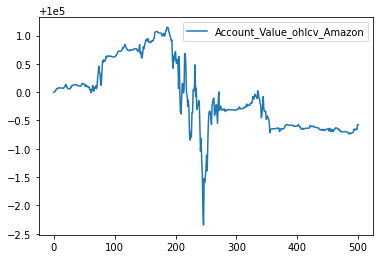

In [13]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline

account_value_files = os.listdir(f'{names[0]}_acc_val')
sharpe_values = {}
for files in account_value_files:
  if files.split("_")[0] == 'Account':
      df = pd.read_csv(f'{names[0]}_acc_val/'+files)
      name = files.split(".")[0][:-4]
      sharpe_values[name] = calculate_sharpe(df)
      plt.plot(df['total_assets'], label=name)
      plt.legend()

In [14]:
print(sharpe_values)

{'Account_Value_ohlcv_Amazon': -0.15281097915163283}
